In [301]:
#import libraries
import os
import numpy as np
import pandas as pd
from pandas import read_csv
from datetime import datetime
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import pickle 
import quandl
import matplotlib.pyplot as plt

In [244]:
#initialize plotly
py.init_notebook_mode(connected=True)

In [308]:
#connect to quandl 
quandl.ApiConfig.api_key = "CpWibLx_pVZzRsJP2xxe"

In [320]:
#function to merge columns by name to new dataframe
def merge_dfs_on_column(dataframes, labels, col):
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
    return pd.DataFrame(series_dict)

In [321]:
#Retrieve BTC USD price
btc_kraken_df = quandl.get("BCHARTS/KRAKENUSD", start_date = "2015-01-02")

In [322]:
#get price data for additional exchanges
exchanges= ['COINBASE', 'BITSTAMP', 'ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_kraken_df

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = quandl.get(exchange_code)
    exchange_data[exchange] = btc_exchange_df
    


In [338]:
#Aggreate average of columns to fill holes in data
btc_high = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'High')
btc_close = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Close')
btc_low = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Low')
btc_volume = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Volume (Currency)')
#create BTC dataframe                               
btc_data = pd.DataFrame()
btc_data['high']=  btc_high.mean(axis=1)
btc_data['close'] = btc_close.mean(axis=1)
btc_data['low'] = btc_low.mean(axis=1)
btc_data['volume'] = btc_volume.mean(axis=1)
btc_data = btc_data.iloc[btc_data.index >= '2015-01-01']


In [339]:
# Plot the new BTC close price
btc_trace = go.Scatter(x=btc_data.index, y=btc_data['close'])
py.iplot([btc_trace])

In [340]:
#connect to poloniex public api
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)


In [341]:
#Poloniex Api call
def get_crypto_data(poloniex_pair):
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    df = pd.read_json(json_url)
    df = df.drop(['open', 'quoteVolume', 'weightedAverage'], axis=1)
    df = df.set_index('date')
    return df

In [342]:
#list of assets to analyze

assets = ['BTC','ETH','LTC','XRP','STR','XMR', 'SP500']
#create dict of dataframes of each asset
asset_data = {}
for asset in assets:
    if asset == 'SP500':
        path = '{}.csv'.format(asset)
        df = read_csv(path)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        asset_data[asset] = df 
    elif asset == 'BTC':
        asset_data[asset] = btc_data
    else:
        coinpair = 'BTC_{}'.format(asset)
        df = get_crypto_data(coinpair)
        temp_two_df = btc_data
        temp_two_df = temp_two_df.reindex(index = df.index, method ='ffill')
        #convert btc-asset pair to USD
        df = df.mul(temp_two_df['close'].fillna(1), axis =0)
        asset_data[asset] = df

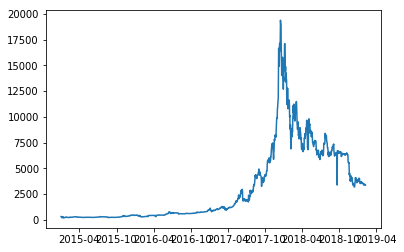

In [343]:
x = asset_data['BTC'].index
y = asset_data['BTC'].close
plt.plot(x,y)
plt.show()

In [344]:
close_price_df = merge_dfs_on_column(list(asset_data.values()), list(asset_data.keys()), 'close')

In [345]:
#plotly charting function
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=True
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [346]:
# Chart all of the assets
df_scatter(close_price_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')


In [349]:
#function to graph heatmap of correlations between different assets
def correlation_heatmap(df, title, absolute_bounds=True):
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)

In [350]:
close_price_df.pct_change().corr(method='pearson')

,BTC,ETH,LTC,XRP,STR,XMR,SP500
BTC,1.000000,0.593523,0.706510,0.462862,0.496206,0.627329,0.034666
ETH,0.593523,1.000000,0.536175,0.365629,0.384974,0.504968,0.042842
LTC,0.706510,0.536175,1.000000,0.443939,0.451595,0.515532,0.048816
XRP,0.462862,0.365629,0.443939,1.000000,0.585661,0.367752,0.046736
STR,0.496206,0.384974,0.451595,0.585661,1.000000,0.434896,0.044863
XMR,0.627329,0.504968,0.515532,0.367752,0.434896,1.000000,0.044263
SP500,0.034666,0.042842,0.048816,0.046736,0.044863,0.044263,1.000000


In [351]:
correlation_heatmap(close_price_df.pct_change(), "Cryptocurrency Price Correlation")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

